## LAB 4 ML 2021-22. - OPTIONAL TASKS FOR LAB 4 (1 POINT)

FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**: ....

### This task consists of a small tutorial to run well know Semantic Segmentation models, and it is based on a tutorial from https://learnopencv.com/  (*semantic-segmentation-using-torchvision*)

Copyright © 2024 – BIG VISION LLC Privacy Policy Terms and Conditions


### Different from the previous notebooks in this Lab, this one uses **pytorch** framework, so you can see an example with this other framework.


## Using torchvision for Semantic Segmentation

The inputs and outputs of these semantic segmentation models are as follows<br/>

**INPUT**: 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image


**OUTPUT**: the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)


The `torchvision` models outputs an `OrderedDict` <br/>
In `.eval()` mode, this dictionary has just one key `out`.
The `out` key of this `OrderedDict` is the key that holds the output. This `out` key's value has the shape of `[No x Co x Ho x Wo]`.
To access it with a network called `fcn` we run

`output_data = fcn(input_data)['out']`


### FCN with Resnet-101 backbone

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation. We are loading a pre-trained FCN with a RESNET101 backbone next

In [1]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

/Users/ignaciopastorebenaim/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ignaciopastorebenaim/anaconda3/envs/tensorflow/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ignaciopastorebenaim/anaconda3/envs/tensorflow/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(m

And now we load one image available online

2024-11-10 21:48:20 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182904/182904] -> "bird.png" [1]


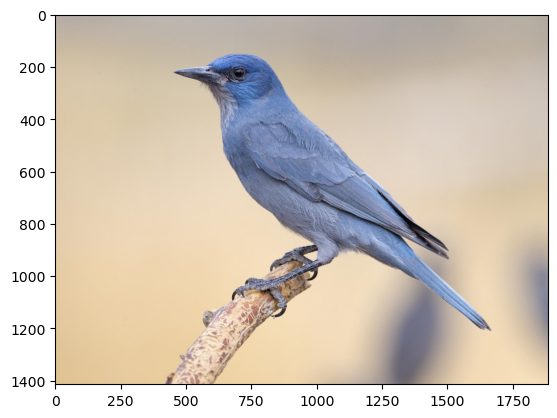

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

Preprocess and normalize the image before passing it to the model! <br/>
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- **Normalize it with the Imagenet specific mean and standard deviation.values** `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

Last, unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>
We need a batch dimension while passing it to the models, even if the batch size in this case is 1.

In [ ]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Pass it through the model and get the `out` key.<br/>

In [ ]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

`out` is the final output of the model. And as we can see, its shape is `[1 x 21 x H x W]`. So, the model was trained on `21` classes and thus our output has `21` channels!<br/>

Next, for visualization and evaluation purposes, make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class

The `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

In [ ]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its corresponding color for better visualization

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):

  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

The image after segmentation is smaller than the original image as in the preprocessing step the image is resized and cropped.

Move all this under one function and run more easily with other images

In [ ]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

### DeepLabv3

With simple images both models are similar, let's try this second model with a more complex scene

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [ ]:
!wget -nv "https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./person.png', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./person.png', show_orig=False)

Here we can appreciate some differences.

For example FCN fails to capture the continuity of the leg of the cow while DeepLabv3 is able to capture that. Also, if we look closer into the hand of the human which is on the cow, we can see that the FCN model captures it better than the DeepLabv3 model.

### Evaluate other aspects: Inference Time

Sample code to compare inference time of both models. In the evaluation of a model, not only the quality of the output is important. Resource requirements (time, memory, ... ) are also very important in real applications.

In [ ]:
import time

def infer_time(net, path='./bird.png', dev='cuda'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256),
                   T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

  inp = trf(img).unsqueeze(0).to(dev)

  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()

  return et - st

**On CPU**

In [ ]:
avg_over = 10

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over
print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

**On GPU**

In [ ]:
avg_over = 10

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

### QUESTION 1: get two variations of the given segmentation models

- Change the segmentation models (e.g. for other versions of FCN or Deeplab) and modify some configuration or hyperparameter

In [ ]:
# put here your snippet of code to run the segmentation with your modification 1

In [ ]:
# put here your snippet of code to run the segmentation with your modification 2

Explain what you have changed and what you expect to change in the output, or what you see is different analyzing the new predictions after each of these changes

ANSWER 1: [YOUR ANSWER HERE] (max 10 lines)

### QUESTION 2: evaluate with more images

* **Collect your own 10-image test set**. No need to have labels. Just pick 10 images or take them with your phone (5 you should find them *easy* for the model. 5 you should *believe* that must be hard for the model).
* **Try running inference on your 10-TEST-IMAGE-SET** (you can upload them to colab and load the same way it's done in previous example) with **two different models** so you can compare the results in your discussion.

Evaluate **qualitatively (no need to label your images)** and **discuss results**. What works well or not? Why? What works or doesn’t as you expected?

In [ ]:
# put here your snippet of code to run the inference on your test images and display the results

ANSWER 2: [YOUR ANSWER HERE] (max 10 lines)